## Single-stock mean reversion¶


       Equity(5938 [PG])
count         903.000000
mean           88.548199
std            15.254685
min            67.770000
25%            78.024000
50%            82.886000
75%            96.044000
max           126.090000
Index([Equity(5938 [PG])], dtype='object')
                               PG
2016-06-01 00:00:00+00:00  73.361
2016-06-02 00:00:00+00:00  73.486
2016-06-03 00:00:00+00:00  73.962
2016-06-06 00:00:00+00:00  74.231
2016-06-07 00:00:00+00:00  73.872


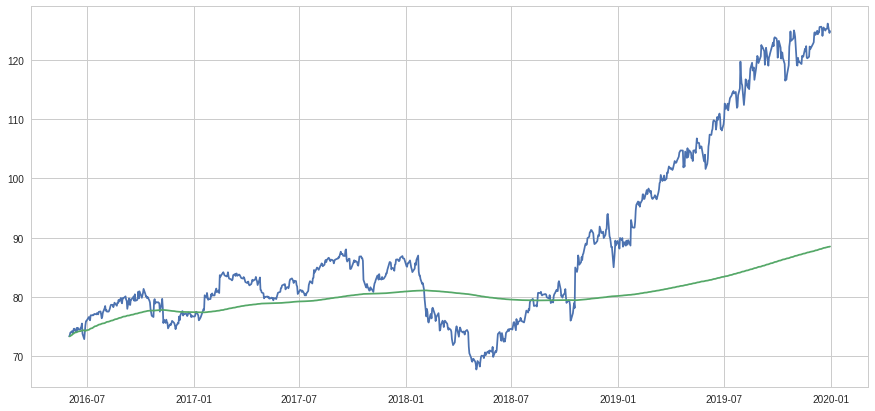

In [140]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# Import pipeline built-ins.
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import SimpleMovingAverage

# Import datasets.
from quantopian.pipeline.data import EquityPricing


# Load the prices data for a stock
start = '2016-06-01'
end = '2019-12-31'
m="PG"
data = get_pricing(m, start_date = start, end_date= end, fields= 'close_price')
prices = data.to_frame()
print(prices.describe())
print(prices.columns)
prices.columns = ['PG']
print(prices.head())

# Compute the cumulative moving average of the price
prices['mu'] = [prices.loc[:][m][:i].mean() for i in range(len(prices))]
# Plot the price and the moving average
plt.figure(figsize=(15,7))
plt.plot(prices)
plt.show()

In [113]:
# Compute the z-scores for each day using the historical data up to that day
zscores = [(prices[:][m][i] - prices['mu'][i]) / np.std(prices[m][:i]) for i in range(len(prices))]

# Start with no money and no positions
money = 0
count = 0
for i in range(len(prices)):
    # Sell short if the z-score is > 1
    if zscores[i] > 1:
        money += prices[m][i]
        count -= 1
    # Buy long if the z-score is < 1
    elif zscores[i] < -1:
        money -= prices[m][i]
        count += 1
    # Clear positions if the z-score between -.5 and .5
    elif abs(zscores[i]) < 0.5:
        money += count*prices[m][i]
        count = 0
print money

33091.47


## Mean reversion portfolio¶


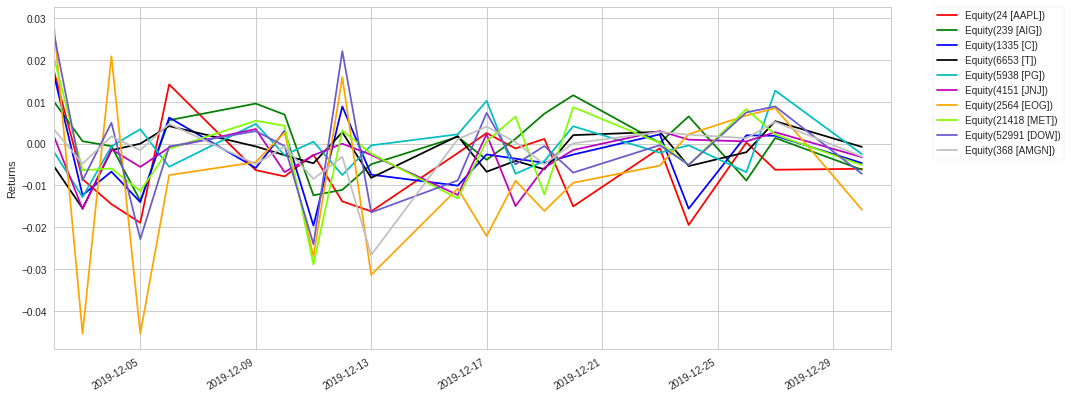

In [148]:
# Fetch prices data for 10 stocks from different sectors and plot returns
start = '2019-12-01'
end = '2019-12-31'
assets = ['AAPL', 'AIG', 'C', 'T', 'PG', 'JNJ', 'EOG', 'MET', 'DOW', 'AMGN']
data = get_pricing(assets, start_date = start, end_date= end)
prices = data['close_price']
returns = prices/prices.shift(-1) -1
returns.plot(figsize=(15,7), color=['r', 'g', 'b', 'k', 'c', 'm', 'orange',
                                     'chartreuse', 'slateblue', 'silver'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Returns')

# Convert to numpy array to make manipulation easier
data = np.array(prices);

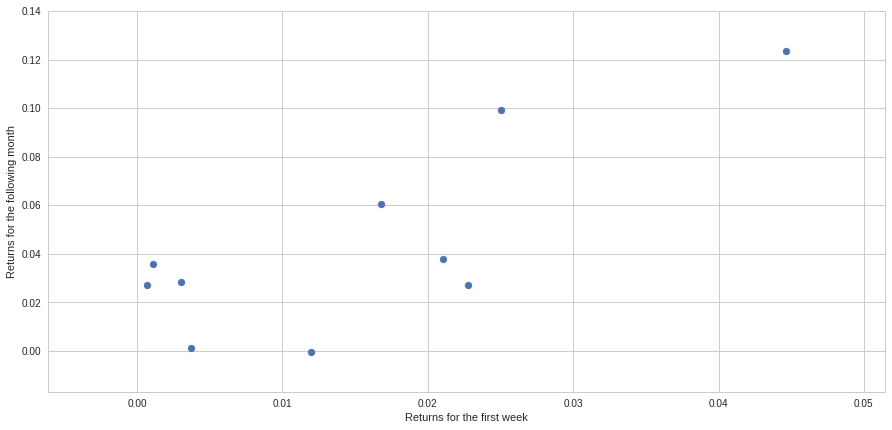

In [149]:
wreturns = (data[4] - data[0])/data[0]
# Rank securities by return, with 0 being the lowest return
order = wreturns.argsort()
ranks = order.argsort()

# For each security, take the return for the month following the first week
# Normalization for the time period doesn't matter since we're only using the returns to rank them
mreturns = (data[-1] - data[5])/data[5]
order2 = mreturns.argsort()
ranks2 = order2.argsort()

# Plot the returns for the first week vs returns for the next month to visualize them
plt.figure(figsize=(15,7))
plt.scatter(wreturns, mreturns)
plt.xlabel('Returns for the first week')
plt.ylabel('Returns for the following month');

In [151]:
# Go long (by one share each) in the bottom 20% of securities and short in the top 20%
longs = np.array([int(x < 7)for x in ranks])
shorts = np.array([int(x < 2) for x in ranks])
print 'Going long in:', [assets[i] for i in range(len(assets)) if longs[i]]
print 'Going short in:', [assets[i] for i in range(len(assets)) if shorts[i]]

# Resolve all positions and calculate how much we would have earned
print 'Yield:', sum((data[-1] - data[4])*(longs - shorts))


Going long in: ['AIG', 'C', 'PG', 'JNJ', 'MET', 'DOW', 'AMGN']
Going short in: ['DOW', 'AMGN']
Yield: 11.425


## Pairs trading

In [161]:
from statsmodels.tsa.stattools import coint
start = '2016-06-01'
end = '2019-12-31'
# Load prices data for HP and Microsoft
assets = ['MSFT', 'HP']
data = get_pricing(assets, start_date = start, end_date= end, fields = 'close_price')
prices = data
prices.columns = ['MSFT', 'HP']
print(prices.columns)
X = data['MSFT']
Y = data['HP']

# Compute the p-value for the cointegration of the two series
_, pvalue, _ = coint(X,Y)
print pvalue

Index(['MSFT', 'HP'], dtype='object')
0.891102161271


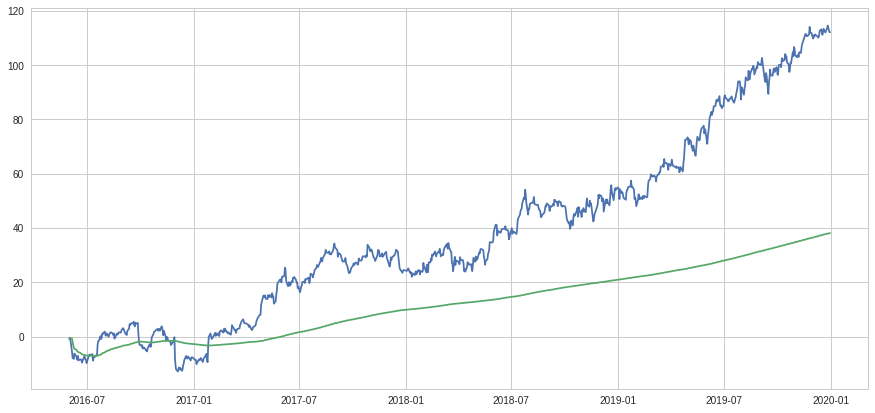

In [162]:
# Plot their difference and the cumulative moving average of their difference
val = pd.DataFrame(index = X.index, columns=['diff','mu'])
val['diff'] = X - Y
val['mu']= [val['diff'][:i].mean() for i in range(len(val['diff']))]
plt.figure(figsize=(15,7))
plt.plot(val['diff'])
plt.plot(val['mu'])
plt.show()

/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
  """Entry point for launching an IPython kernel.


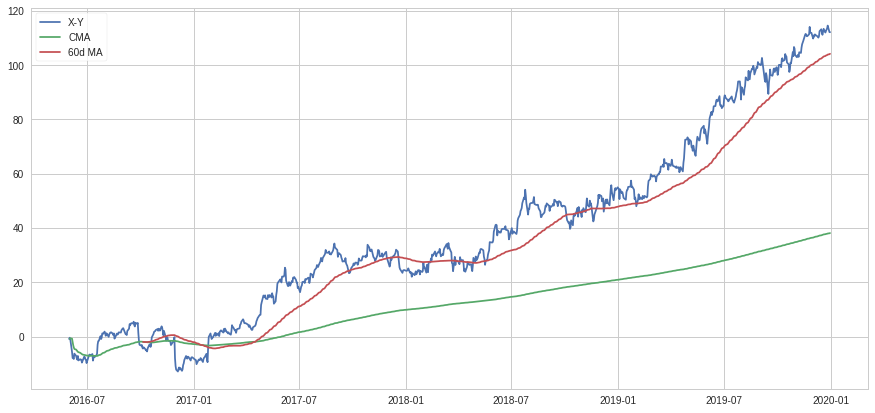

In [163]:
mu_60d = pd.rolling_mean(val['diff'], window=90)
plt.figure(figsize=(15,7))
plt.plot(val['diff'], label='X-Y')
plt.plot(val['mu'], label='CMA')
plt.plot(mu_60d, label='60d MA')
plt.legend();

In [164]:
# Compute the z-score of the difference on each day
zscores = [(val['diff'][i] - val['mu'][i]) / np.std(val['diff'][:i]) for i in range(len(val['diff']))]

# Start with no money and no positions
money = 0
count = 0
for i in range(len(val['diff'])):
    # Sell short if the z-score is > 1
    if zscores[i] > 1:
        money += val['diff'][i]
        count -= 1
    # Buy long if the z-score is < 1
    elif zscores[i] < -1:
        money -= val['diff'][i]
        count += 1
    # Clear positions if the z-score between -.5 and .5
    elif abs(zscores[i]) < 0.5:
        money += count*val['diff'][i]
        count = 0
        
print money

34482.317
